In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as T
from torchmetrics import F1Score

In [2]:
! ls data/Master\ Folder/train

Angry  happy  Other  Sad


In [3]:
transforms = T.Compose([
    T.ToTensor(),
])


from PIL import Image
img = Image.open('data/happy/001.jpg')
img = transforms(img)
img.shape

torch.Size([3, 224, 224])

In [4]:
train_path = 'data/Master Folder/train'
test_path = 'data/Master Folder/test'
valid_path = 'data/Master Folder/valid'

In [5]:
class_to_index = {'happy': 0, 'not_happy': 1}
class_to_index.get('happy')

0

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms=None, happy_transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.happy_transforms = happy_transforms
        self.class_to_index = {'happy': 0, 'not_happy': 1}
        self.image_paths = self._load_image_paths()

    def get_class_index(self, name):
        return self.class_to_index.get(name, -1)

    def _load_image_paths(self):
        image_paths = []
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                class_idx = self.get_class_index(class_name)
                if class_idx != -1:
                    for filename in os.listdir(class_dir):
                        image_paths.append((os.path.join(class_dir, filename), class_idx))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transforms:
            image = self.transforms(image)
            
        if self.happy_transforms and label == 0:
            image = T.ToPILImage()(image) 
            image = self.happy_transforms(image)

        label_tensor = torch.zeros(2)
        label_tensor[label] = 1

        return image, label_tensor


In [7]:

happy_transforms = T.Compose([
    T.RandomResizedCrop(size = 157, antialias=True),
    T.RandomHorizontalFlip(p = 0.5),
    T.ToTensor(),
])


transforms = T.Compose([
    T.Resize(157),
    T.ToTensor(),
])

In [8]:
train_ds = CustomDataset(root_dir=train_path, transforms=transforms, happy_transforms = happy_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle = True)

In [9]:
test_ds = CustomDataset(root_dir=test_path, transforms=transforms)
test_dataloader = DataLoader(test_ds, shuffle= False)

In [10]:
train_image_batch, train_image_label = next(iter(train_loader))

In [11]:
train_image_batch[20], train_image_label[20]

(tensor([[[0.0745, 0.0667, 0.0706,  ..., 0.0588, 0.0627, 0.0902],
          [0.0627, 0.0549, 0.0549,  ..., 0.1020, 0.0784, 0.0941],
          [0.0745, 0.0667, 0.0627,  ..., 0.1137, 0.0902, 0.0863],
          ...,
          [0.1255, 0.1490, 0.1569,  ..., 0.1961, 0.1922, 0.1843],
          [0.1608, 0.1882, 0.1961,  ..., 0.2118, 0.2196, 0.2078],
          [0.1804, 0.2196, 0.2235,  ..., 0.2314, 0.2510, 0.2392]],
 
         [[0.0706, 0.0588, 0.0627,  ..., 0.0471, 0.0510, 0.0745],
          [0.0588, 0.0510, 0.0510,  ..., 0.0902, 0.0667, 0.0784],
          [0.0667, 0.0588, 0.0588,  ..., 0.0980, 0.0745, 0.0745],
          ...,
          [0.1137, 0.1333, 0.1412,  ..., 0.1451, 0.1412, 0.1294],
          [0.1451, 0.1725, 0.1804,  ..., 0.1608, 0.1647, 0.1490],
          [0.1647, 0.2039, 0.2039,  ..., 0.1804, 0.1922, 0.1725]],
 
         [[0.0510, 0.0392, 0.0353,  ..., 0.0275, 0.0275, 0.0510],
          [0.0431, 0.0353, 0.0314,  ..., 0.0667, 0.0431, 0.0588],
          [0.0510, 0.0431, 0.0392,  ...,

In [12]:
train_image_batch.shape

torch.Size([64, 3, 157, 157])

In [13]:
class_names = list(train_ds.class_to_index.keys())

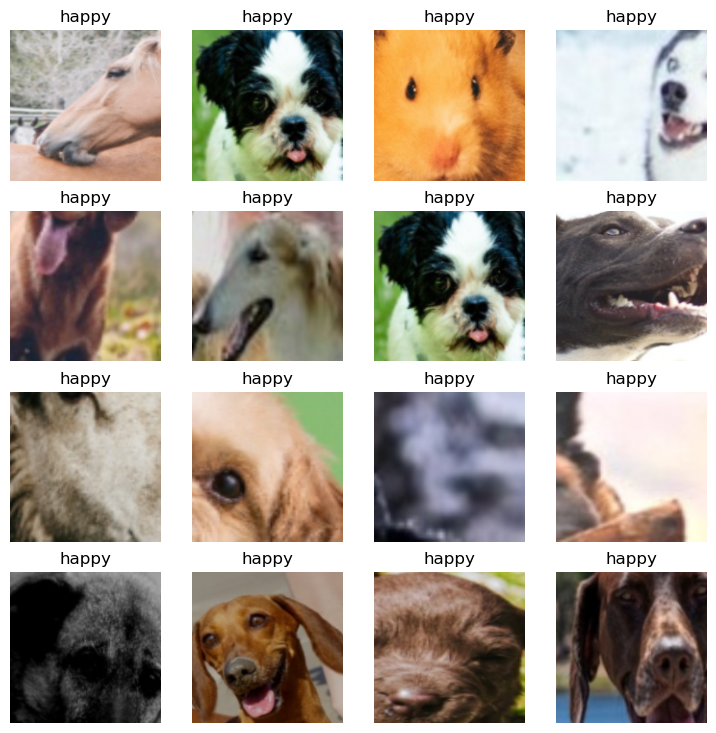

In [14]:
fig = plt.figure(figsize = (9,9))

rows, cols = 4,4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_image_batch), size = [1]).item()
    img_data, label = train_image_batch[random_idx], train_image_label[random_idx]
    img = np.transpose(img_data.squeeze(), (1,2,0))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(class_names[label.argmax()])
    plt.axis('Off')

In [15]:
class BaselineExpressionModelV0(nn.Module):
    def __init__(self, num_classes: int):
        super(BaselineExpressionModelV0, self).__init__()
        
        
        # self.transforms = T.Compose([
        #     T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        # ])
        
        self.features = nn.Sequential(
            # First Layer
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 11, stride = 4, padding = 2),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Dropout(p=0.5),
            
            # Second Layer 
            nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(num_features = 192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            # Third Layer
            nn.Conv2d(in_channels = 192, out_channels = 384, kernel_size = 5, padding = 1),
            nn.BatchNorm2d(num_features = 384),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            # Fourth Layer
            nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 5, padding = 1),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            # Fifth Layer
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier = nn.Sequential(
            # Sixth Layer
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(), 
            
            # Seventh Layer
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            
            # Eighth Layer
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x = self.transforms(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x 
            

In [16]:
model_0 = BaselineExpressionModelV0(num_classes = len(class_names))

In [17]:
numel_list = [p.numel() for p in model_0.parameters()]
sum(numel_list)

60815426

In [18]:
optim = torch.optim.SGD(params = model_0.parameters(), lr = 1e-3, weight_decay = 0.3)
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = F1Score(task = 'multiclass', num_classes =2)

In [19]:
train_image_batch[0].T.shape

/tmp/ipykernel_11678/3800624836.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904639/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  train_image_batch[0].T.shape


torch.Size([157, 157, 3])

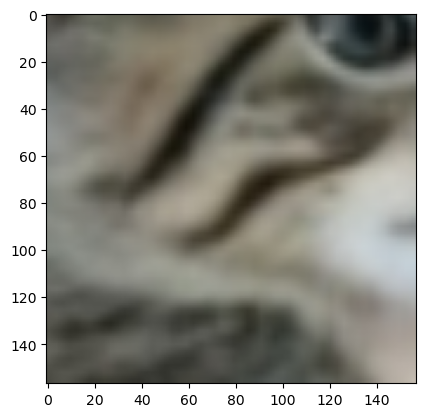

In [20]:
plt.imshow(np.transpose(train_image_batch[3], (1,2,0)))

In [21]:
pred = model_0(train_image_batch[60].unsqueeze(dim = 0))

In [22]:
target = train_image_label[20]

In [23]:
pred, target

(tensor([[-0.4101,  0.2248]], grad_fn=<AddmmBackward0>), tensor([1., 0.]))

In [24]:
dummy_prediction = torch.argmax(torch.sigmoid(pred))
dummy_target = torch.argmax(target)
class_names[dummy_prediction], class_names[dummy_target]

('not_happy', 'happy')

In [25]:
acc_fn(pred, target).item()

0.5

In [26]:
loss = loss_fn(pred, target.unsqueeze(dim = 0))

In [27]:
loss

tensor(0.8655, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [37]:
def train(net, epochs, trainloader, testloader, optimizer, criterion, acc_fn, device = 'cpu',):
    epochs_count = list()
    train_loss_count = list()
    test_loss_count = list()
    
    # loop over the dataset multiple times
    for epoch in range(1, epochs):
        print(f'Epoch: {epoch}')
        
        training_loss = .0
        training_acc = .0
        net.train()
        for i, batch in enumerate(trainloader, 0):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_acc = acc_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            training_loss += loss.item()
            training_acc += train_acc.item()
            
        training_loss /= len(trainloader)
        train_loss_count.append(training_loss)
        training_acc /= len(trainloader)
        
        print(f'Train Loss: {training_loss}, Training Accuracy : {training_acc}')
        
        testing_loss, testing_acc = .0, .0
        net.eval()
        with torch.inference_mode():
            for test_batch in testloader:
                test_inputs, test_labels = test_batch
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                
                test_outputs = net(test_inputs)
                loss = criterion(test_outputs, test_labels)
                test_acc = acc_fn(outputs, labels)
                
                testing_loss += loss
                testing_acc += test_acc.item()
                
            testing_loss /= len(testloader)
            test_loss_count.append(testing_loss)
            testing_acc /= len(testloader)
            
        epochs_count.append(epoch)
        
        
        print(f'Test Loss: {testing_loss}, Test Accuracy : {testing_acc}')
        print('-------------------------------------------------------')
        print('-------------------------------------------------------')
    
    print('Finished Training')
    
    return {
        'epochs': epochs_count,
        'train_loss': train_loss_count,
        'test_loss': test_loss_count
    }

In [38]:
history = train(net = model_0, epochs = 10, trainloader=train_loader, testloader=test_dataloader, optimizer=optim, criterion=loss_fn, acc_fn=acc_fn)

Epoch: 1
Train Loss: 0.06592885963618755, Training Accuracy : 0.0
Test Loss: 0.16877993941307068, Test Accuracy : 0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch: 2
Train Loss: 0.058643816970288754, Training Accuracy : 0.0
Test Loss: 0.13259831070899963, Test Accuracy : 0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch: 3
Train Loss: 0.053794837556779385, Training Accuracy : 0.0
Test Loss: 0.10586473345756531, Test Accuracy : 0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch: 4
Train Loss: 0.04876018315553665, Training Accuracy : 0.0
Test Loss: 0.08616168797016144, Test Accuracy : 0.0
-------------------------------------------------------
-------------------------------------------------------
Finished Training


In [39]:
history['epochs']

[1, 2, 3, 4]

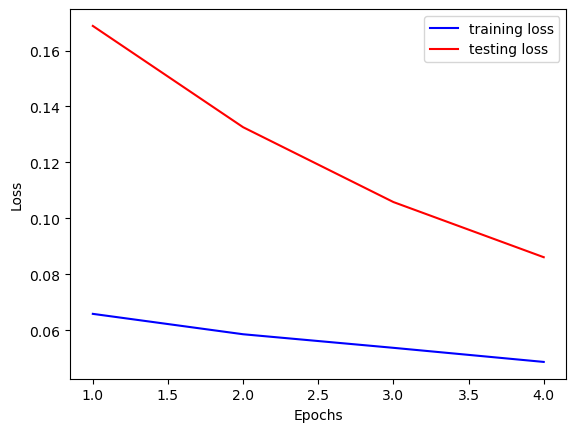

In [40]:
plt.plot(history['epochs'], history['train_loss'], c= 'b', label = 'training loss')
plt.plot(history['epochs'], history['test_loss'], c = 'r', label = 'testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 0)